**Peers In Multiple Tunnels**

✅ Data shape: (4222793, 8)


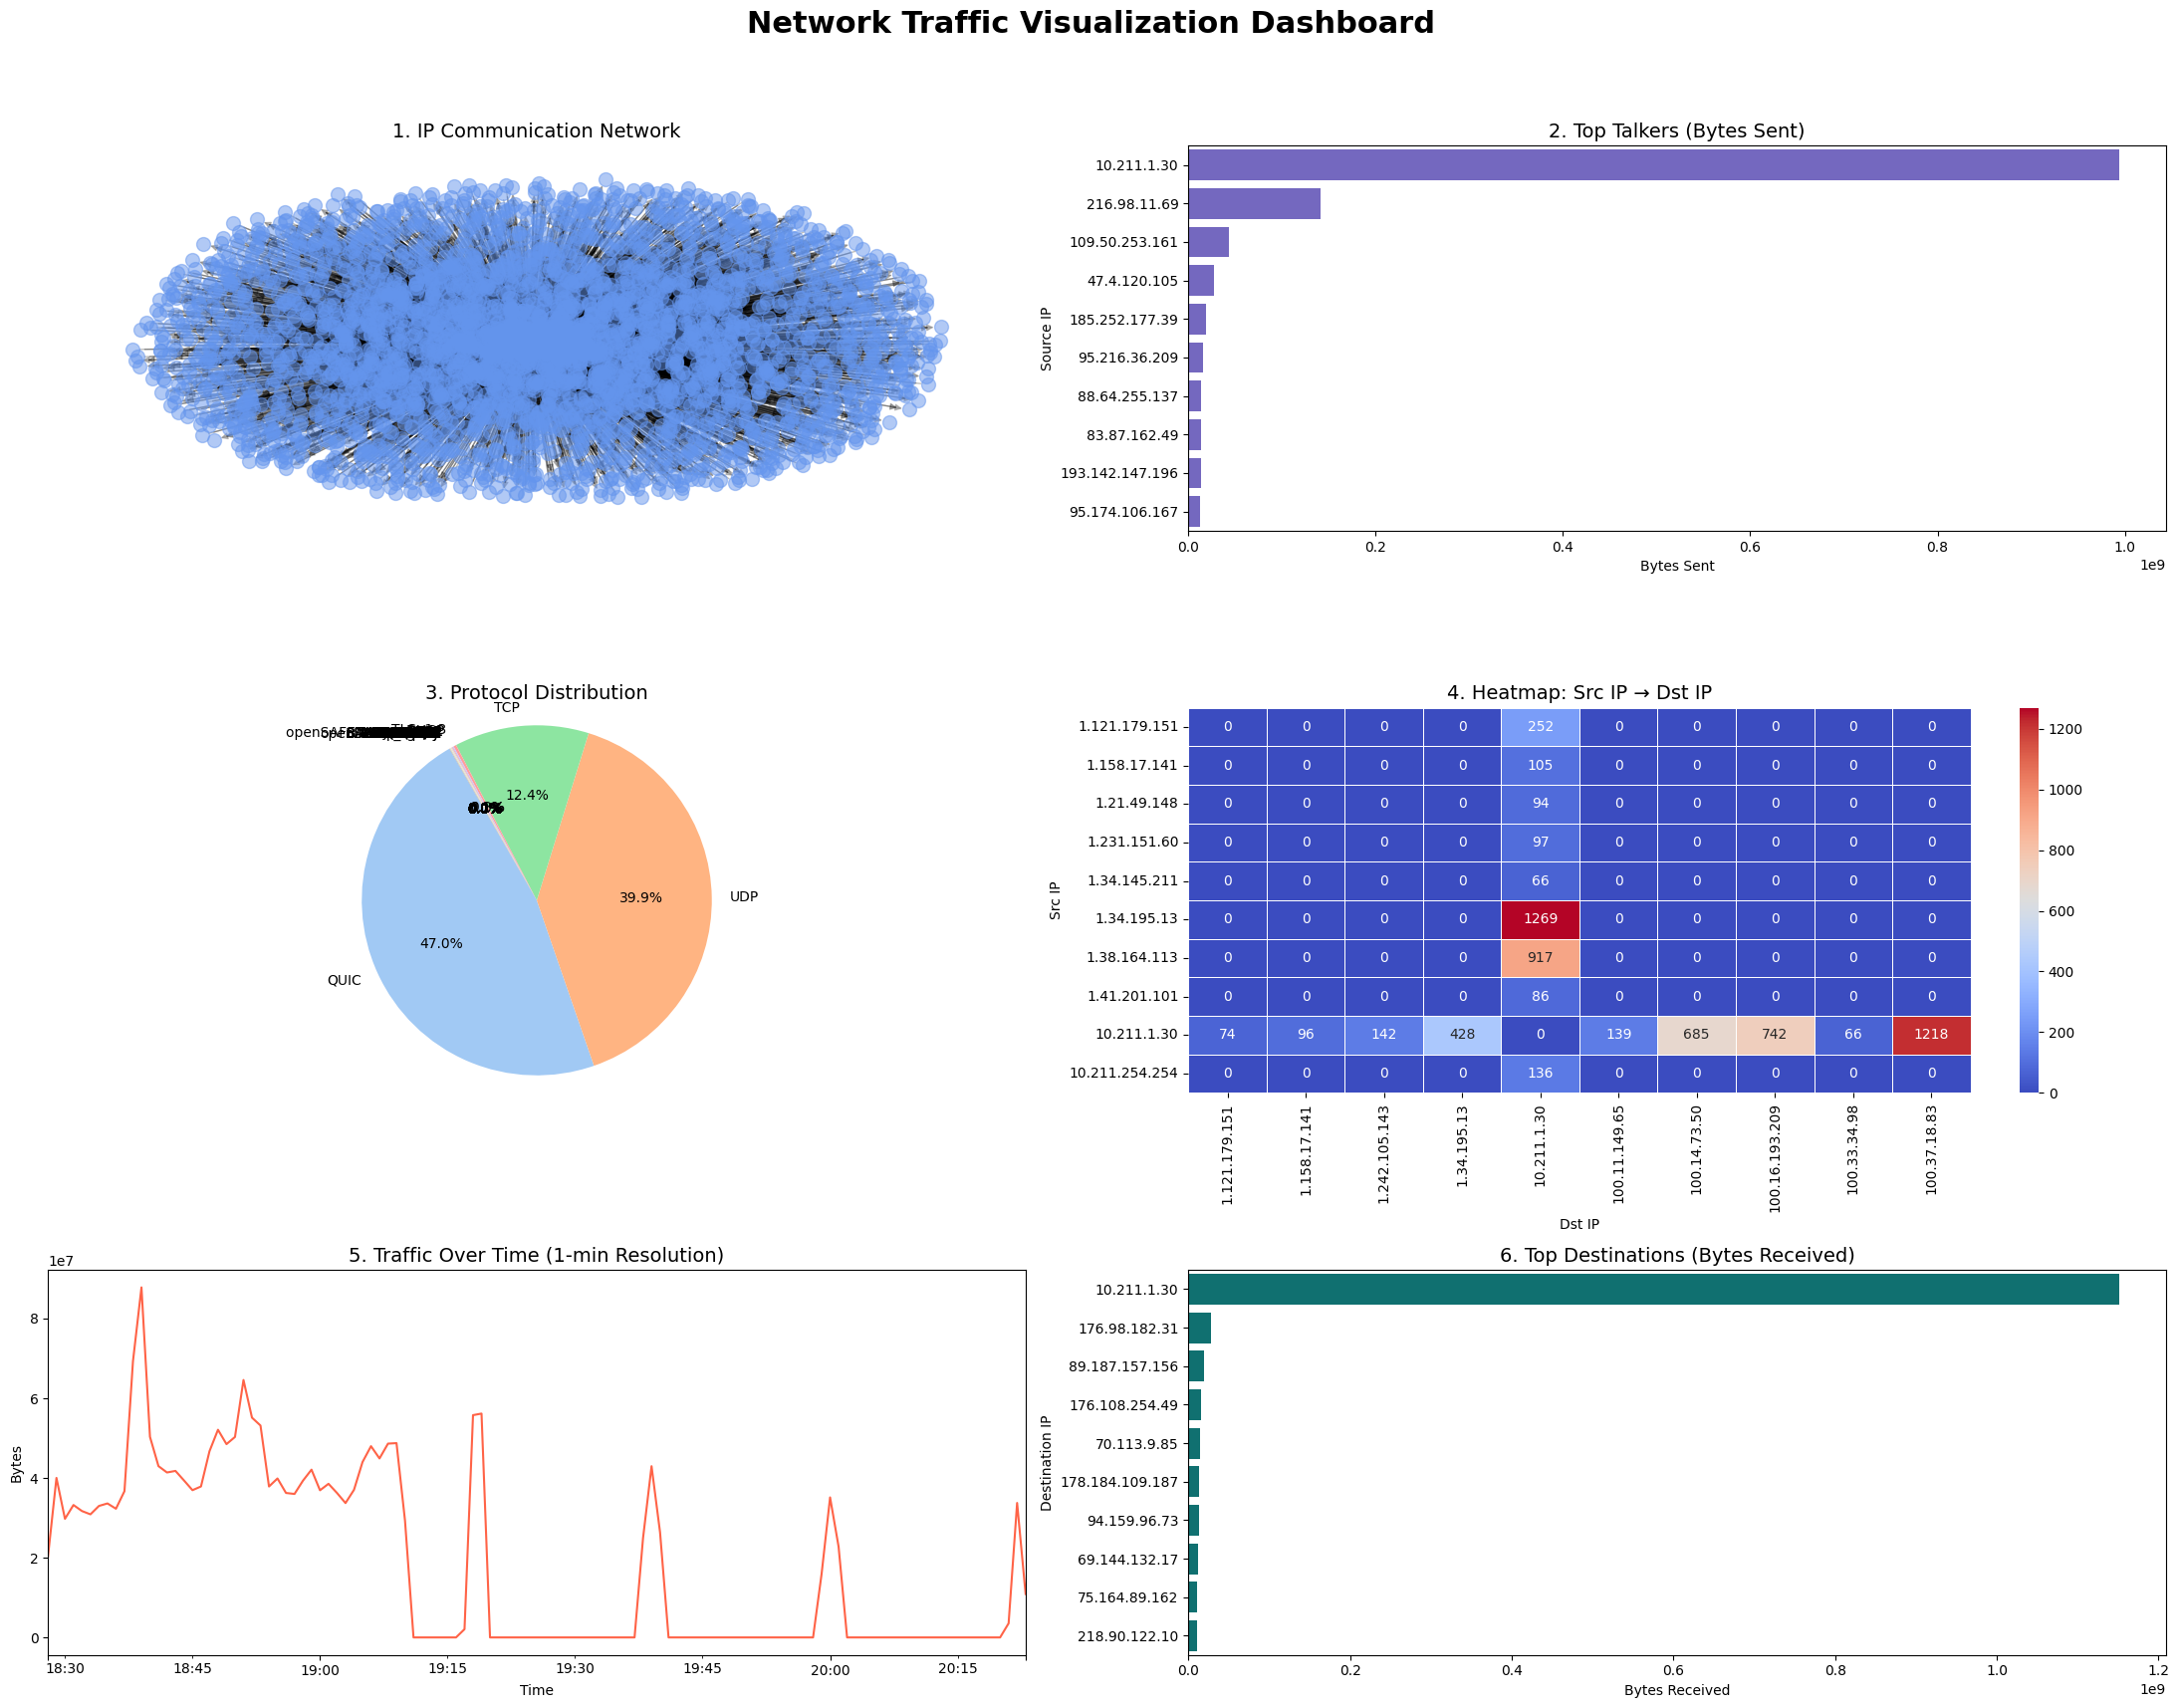

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Load data
df = pd.read_csv(
    "/content/drive/MyDrive/I2P RESEARCH/DataInBrief/7-i2pmetadata-4-17-25-final-cleaned.csv",
    low_memory=False,
    parse_dates=['Time']
)

print("✅ Data shape:", df.shape)

# Downsample intelligently if necessary
max_rows = 20000
df_sample = df.sample(n=max_rows, random_state=42) if df.shape[0] > max_rows else df

# Network edges
graph_data = df_sample.groupby(['Src IP', 'Dst IP'])['PacketSize(Bytes)'].sum().reset_index()

# Create layout
fig, axs = plt.subplots(3, 2, figsize=(22, 18))
fig.suptitle("Network Traffic Visualization Dashboard", fontsize=22, fontweight='bold')

# --- 1. NETWORK GRAPH ---
G = nx.DiGraph()
for _, row in graph_data.iterrows():
    G.add_edge(row['Src IP'], row['Dst IP'], weight=row['PacketSize(Bytes)'])

pos = nx.spring_layout(G, k=0.6, iterations=50, seed=42)
ax = axs[0, 0]
nx.draw(
    G, pos, ax=ax,
    node_size=100,
    node_color='cornflowerblue',
    edge_color='gray',
    alpha=0.5,
    with_labels=False
)
nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.3)
ax.set_title("1. IP Communication Network", fontsize=14)

# --- 2. BAR CHART: Top Talkers ---
top_senders = df.groupby('Src IP')['PacketSize(Bytes)'].sum().sort_values(ascending=False).head(10)
ax = axs[0, 1]
sns.barplot(x=top_senders.values, y=top_senders.index, color='slateblue', ax=ax)
ax.set_title("2. Top Talkers (Bytes Sent)", fontsize=14)
ax.set_xlabel("Bytes Sent")
ax.set_ylabel("Source IP")

# --- 3. PIE CHART: Protocol Usage ---
proto_counts = df['Proto'].value_counts()
ax = axs[1, 0]
ax.pie(proto_counts, labels=proto_counts.index, autopct='%1.1f%%', startangle=120,
       colors=sns.color_palette("pastel"))
ax.set_title("3. Protocol Distribution", fontsize=14)
ax.axis('equal')

# --- 4. HEATMAP: IP-to-IP Matrix ---
pivot = df_sample.pivot_table(index='Src IP', columns='Dst IP', values='PacketSize(Bytes)', aggfunc='sum', fill_value=0)
pivot = pivot.iloc[:10, :10]  # readable slice
ax = axs[1, 1]
sns.heatmap(pivot, cmap="coolwarm", ax=ax, annot=True, fmt=".0f", linewidths=0.5, cbar=True)
ax.set_title("4. Heatmap: Src IP → Dst IP", fontsize=14)

# --- 5. TIME SERIES: Traffic Over Time ---
ts = df.set_index("Time").resample('1Min')['PacketSize(Bytes)'].sum()
ax = axs[2, 0]
ts.plot(ax=ax, color='tomato')
ax.set_title("5. Traffic Over Time (1-min Resolution)", fontsize=14)
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")

# --- 6. BAR CHART: Top Destination IPs ---
top_dsts = df.groupby('Dst IP')['PacketSize(Bytes)'].sum().sort_values(ascending=False).head(10)
ax = axs[2, 1]
sns.barplot(x=top_dsts.values, y=top_dsts.index, color='teal', ax=ax)
ax.set_title("6. Top Destinations (Bytes Received)", fontsize=14)
ax.set_xlabel("Bytes Received")
ax.set_ylabel("Destination IP")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
